In [1]:
import pandas as pd
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from binance.client import Client
import urllib.request
from datetime import date, timedelta
import datetime
import zipfile
import tqdm
from pandarallel import pandarallel
import os
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
def hex2int(x):
    return int(x, 16)

def reformat_log(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'topic0 current roundId updatedAt'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    data['updatedAt'] = pd.to_datetime(data['updatedAt'],unit='s')
    data['current'] = data['current'] / 10**8
    return data

# Chainlink

In [29]:
# time_data_list = [] 
# for i in range(2,7):
#     tmp_df = pd.read_csv(f'data/crawled/blockTime_data_{i}.csv', index_col='blockNum')
#     time_data_list.append(tmp_df)
# time_data = pd.concat(time_data_list)
# time_data = time_data.sort_index().drop_duplicates()
# time_data['blockTime'] = pd.to_datetime(time_data['blockTime'],unit='s')
# time_data

In [30]:
chainlink_df = pd.read_csv('data/crawled/chainlink_eth_usd.csv', index_col='blockNum')
chainlink_df = reformat_log(chainlink_df)
chainlink_df.head()

,topic0,current,roundId,updatedAt
blockNum,,,,
12466826,2419754421309073239616474162343765982017095847...,2603.219547,1261,2021-05-19 19:55:33
12466847,2419754421309073239616474162343765982017095847...,2606.088954,1262,2021-05-19 19:59:06
12466859,2419754421309073239616474162343765982017095847...,2622.125382,1263,2021-05-19 20:01:40
12466872,2419754421309073239616474162343765982017095847...,2638.169486,1264,2021-05-19 20:03:45
12466878,2419754421309073239616474162343765982017095847...,2653.400000,1265,2021-05-19 20:04:23


In [28]:
# chainlink_df.merge(time_data, on='blockNum')

,topic0,current,roundId,updatedAt,blockTime
blockNum,,,,,
13000008,2419754421309073239616474162343765982017095847...,3170.877087,8470,2021-08-10 21:55:11,2021-08-10 21:55:11
13000188,2419754421309073239616474162343765982017095847...,3153.800591,8471,2021-08-10 22:37:16,2021-08-10 22:37:16
13000285,2419754421309073239616474162343765982017095847...,3155.902989,8472,2021-08-10 22:55:49,2021-08-10 22:55:49
13000431,2419754421309073239616474162343765982017095847...,3138.158417,8473,2021-08-10 23:26:25,2021-08-10 23:26:25
13000554,2419754421309073239616474162343765982017095847...,3144.553239,8474,2021-08-10 23:55:17,2021-08-10 23:55:17
...,...,...,...,...,...
14837901,2419754421309073239616474162343765982017095847...,1967.730000,24856,2022-05-24 20:55:32,2022-05-24 20:55:32
14838159,2419754421309073239616474162343765982017095847...,1978.477569,24857,2022-05-24 21:55:45,2022-05-24 21:55:45
14838407,2419754421309073239616474162343765982017095847...,1981.240949,24858,2022-05-24 22:55:39,2022-05-24 22:55:39


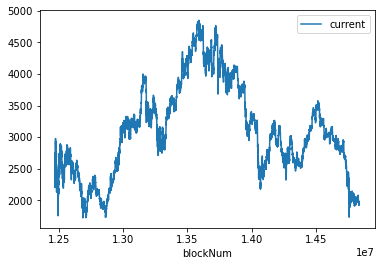

In [52]:
lines = chainlink_df.plot.line( y='current')

In [49]:
import pickle
with open(r"./data/price/chainlink_eth_usd.pickle", "wb") as output_file:
    pickle.dump(chainlink_df, output_file)

In [41]:
with open(r"./data/price/chainlink_eth_usd.pickle", "rb") as output_file:
    chainlink_df = pickle.load(output_file)

# Uniswap V2

In [6]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

token = "usdc"

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/uniswap_v2_eth_{token}_{blockFrom}_{blockTo}.csv', index_col=False)
    df['index'] = df['blockNum']
    df['blockNum'] = df['reserve1']
    cut_point = int(len(df['reserve0'].iloc[0])/2)
    df['reserve1'] = df['reserve0'].apply(lambda x: x[cut_point:])
    df['reserve0'] = df['reserve0'].apply(lambda x: x[:cut_point])
    df.sort_values(['blockNum', 'index'])
    blockFrom = blockTo
    df_list.append(df)

raw_uniswap_v2_df = pd.concat(df_list)
raw_uniswap_v2_df.tail()

,topic0,reserve0,reserve1,blockNum,index
5902,0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78b...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000009...,14849945,620
5903,0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78b...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000009...,14849945,684
5904,0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78b...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000009...,14849946,58
5905,0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78b...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000009...,14849946,415
5906,0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78b...,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000009...,14849949,24


In [8]:
def reformat_log_uniswap(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'topic0 reserve0 reserve1'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    if token == 'usdc':
        data['reserve0'] = data['reserve0'] / 10**6 
        data['reserve1'] = data['reserve1'] / 10**(22-4)
    elif token == 'usdt':
        data['reserve0'] = data['reserve0'] / 10**(12+6) # 10**6 后面这个是usdc的
        data['reserve1'] = data['reserve1'] / 10**6 #/ 10**(22-4)
    return data
uniswap_v2_df = reformat_log_uniswap(raw_uniswap_v2_df)
if token == 'usdt':
    uniswap_v2_df['price'] = uniswap_v2_df['reserve0']/ uniswap_v2_df['reserve1'] 
elif token == 'usdc':
    uniswap_v2_df['price'] = uniswap_v2_df['reserve1']/ uniswap_v2_df['reserve0'] # uniswap_v2_df['reserve0']/ uniswap_v2_df['reserve1'] 后面这个是usdc的

uniswap_v2_df

,topic0,reserve0,reserve1,blockNum,index,price
0,1277981603965341813014744394350890904319751521...,1.102202e+08,42538.670018,12466826,119,2591.058941
1,1277981603965341813014744394350890904319751521...,1.103091e+08,42504.477966,12466826,131,2595.235568
2,1277981603965341813014744394350890904319751521...,1.103098e+08,42504.208705,12466827,22,2595.268498
3,1277981603965341813014744394350890904319751521...,1.103167e+08,42501.560545,12466827,192,2595.592404
4,1277981603965341813014744394350890904319751521...,1.103254e+08,42498.232151,12466827,199,2595.999597
...,...,...,...,...,...,...
5902,1277981603965341813014744394350890904319751521...,7.791913e+07,42809.762751,14849945,620,1820.125201
5903,1277981603965341813014744394350890904319751521...,7.791677e+07,42811.062814,14849945,684,1820.014824
5904,1277981603965341813014744394350890904319751521...,7.791136e+07,42814.044286,14849946,58,1819.761729
5905,1277981603965341813014744394350890904319751521...,7.791203e+07,42813.677612,14849946,415,1819.792947


In [9]:
with open(f"./data/price/uniswap_v2_eth_{token}_raw.pickle", "wb") as output_file:
    pickle.dump(uniswap_v2_df, output_file)

In [175]:
uniswap_v2_df.tail()

,topic0,reserve0,reserve1,blockNum,index,price
2616,1277981603965341813014744394350890904319751521...,24221.374501,4.428476e+07,14849934,9,1828.333975
2617,1277981603965341813014744394350890904319751521...,24237.312413,4.425573e+07,14849938,266,1825.933825
2618,1277981603965341813014744394350890904319751521...,24244.969195,4.424179e+07,14849938,672,1824.782443
2619,1277981603965341813014744394350890904319751521...,24244.781751,4.424214e+07,14849943,350,1824.810702
2620,1277981603965341813014744394350890904319751521...,24264.260536,4.420673e+07,14849949,38,1821.886434


In [176]:
uniswap_v2_price_df = uniswap_v2_df[['blockNum', 'price']].groupby("blockNum").agg("mean")

In [177]:
with open(r"./data/price/uniswap_v2_eth_usdt.pickle", "wb") as output_file:
    pickle.dump(uniswap_v2_price_df, output_file)

# Uniswap V3

In [13]:
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

coin_name = 'usdc'
fee_pct = "03"

In [30]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

# coin_name = 'usdc'
# fee_pct = "03"

coin_name = 'usdc'
fee_pct = "005"

# coin_name = 'usdt'
# fee_pct = "03"

# coin_name = 'usdt'
# fee_pct = "005"

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/uniswap_v3_eth_{coin_name}_{fee_pct}_{blockFrom}_{blockTo}.csv', index_col=False)
    df['sender'] = df['topic1']
    del df['topic1']
    df['recipient'] = df['topic2']
    del df['topic2']
    cut_gap = int(len(df['Data'].iloc[0])/5)
    cut_start = 0
    for i, new_col in enumerate("amount0 amount1 sqrtPriceX96 liquidity tick".split(" ")):
        cut_end = cut_start + cut_gap
        df[new_col] = df['Data'].apply(lambda x: hex2int(x[cut_start:cut_end]))
        cut_start = cut_end
    del df['Data']
    df.sort_values(['blockNum', 'index'])
    blockFrom = blockTo
    df_list.append(df)

raw_uniswap_v3_df = pd.concat(df_list)
raw_uniswap_v3_df.tail()

,topic0,blockNum,index,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick
22336,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856500,333,0x00000000000000000000000068b3465833fb72a70ecd...,0x0000000000000000000000009becf91e0c6abff22c66...,1157920892373161954235709850086879078532699846...,200000000000000000,1894939145674173671867904173250681,14875747835686305295,201657
22337,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,522,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,8000000000,1157920892373161954235709850086879078532699846...,1894914784436682657644480103388627,14875747835686305295,201657
22338,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,545,0x00000000000000000000000068b3465833fb72a70ecd...,0x00000000000000000000000068b3465833fb72a70ecd...,1157920892373161954235709850086879078532699846...,2000000000000000000,1894925431101214445034018576294279,14875747835686305295,201657
22339,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,569,0x00000000000000000000000068b3465833fb72a70ecd...,0x0000000000000000000000005a21bab0ba75554e37df...,1157920892373161954235709850086879078532699846...,950000000000000000,1894930488266867044044049350924463,14875747835686305295,201657
22340,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856506,87,0x00000000000000000000000068b3465833fb72a70ecd...,0x00000000000000000000000068b3465833fb72a70ecd...,174900048,1157920892373161954235709850086879078532699846...,1894929955667340691498299552379908,14875747835686305295,201657


In [31]:
if coin_name == 'usdc':
    def cal_price(sqrtPriceX96):
        return 1 / ((sqrtPriceX96 ** 2) / ((2 ** 96) ** 2) / 10**(8+4))
else:
    def cal_price(sqrtPriceX96):
        return ((sqrtPriceX96 ** 2) / ((2 ** 96) ** 2)) * 10**(8+4)

def reformat_log_uniswap_v3(raw_data):
    data = copy.deepcopy(raw_data)
    # for col_name in 'amount0 amount1 sqrtPriceX96 liquidity tick'.split(' '):
    # for col_name in 'sqrtPriceX96'.split(' '):
    #     data[col_name] = raw_data[col_name].map(hex2int)
    # data['reserve0'] = data['reserve0'] / 10**(12+6) # 10**6 后面这个是usdc的
    # data['reserve1'] = data['reserve1'] / 10**6 #/ 10**(22-4)
    data['price'] = data['sqrtPriceX96'].apply(cal_price)
    return data
uniswap_v3_df = reformat_log_uniswap_v3(raw_uniswap_v3_df)
# uniswap_v2_df['price'] = uniswap_v2_df['reserve1']/ uniswap_v2_df['reserve0'] # uniswap_v2_df['reserve0']/ uniswap_v2_df['reserve1'] 后面这个是usdc的

uniswap_v3_df

,topic0,blockNum,index,sender,recipient,amount0,amount1,sqrtPriceX96,liquidity,tick,price
0,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,12466903,316,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,1050000000,1157920892373161954235709850086879078532699846...,1529190634136766794617024733037116,1325240225404338,197368,2684.330022
1,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,12466958,202,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000c5e5eadb8ae93967e819...,1157920892373161954235709850086879078532699846...,150000000000000000,1538153750436173532210914591978642,1325240225404338,197485,2653.136962
2,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,12467055,279,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,1157920892373161954235709850086879078532699846...,190000000000000000,1546555334237387854469000818813878,1790831890541486,197594,2624.389195
3,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,12467095,324,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,1157920892373161954235709850086879078532699846...,55701880000000000,1549018407988467770430586334797189,1790831890541486,197625,2616.049817
4,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,12467110,123,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,1157920892373161954235709850086879078532699846...,253550630226332900,1560230128344769038826688775874007,1790831890541486,197770,2578.587349
...,...,...,...,...,...,...,...,...,...,...,...
22336,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856500,333,0x00000000000000000000000068b3465833fb72a70ecd...,0x0000000000000000000000009becf91e0c6abff22c66...,1157920892373161954235709850086879078532699846...,200000000000000000,1894939145674173671867904173250681,14875747835686305295,201657,1748.109498
22337,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,522,0x000000000000000000000000e592427a0aece92de3ed...,0x000000000000000000000000e592427a0aece92de3ed...,8000000000,1157920892373161954235709850086879078532699846...,1894914784436682657644480103388627,14875747835686305295,201657,1748.154446
22338,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,545,0x00000000000000000000000068b3465833fb72a70ecd...,0x00000000000000000000000068b3465833fb72a70ecd...,1157920892373161954235709850086879078532699846...,2000000000000000000,1894925431101214445034018576294279,14875747835686305295,201657,1748.134802
22339,0xc42079f94a6350d7e6235f29174924f928cc2ac818eb...,14856501,569,0x00000000000000000000000068b3465833fb72a70ecd...,0x0000000000000000000000005a21bab0ba75554e37df...,1157920892373161954235709850086879078532699846...,950000000000000000,1894930488266867044044049350924463,14875747835686305295,201657,1748.125471


In [32]:
uniswap_v3_df = uniswap_v3_df["blockNum index price".split(' ')]
uniswap_v3_df.columns = ['BlockNum', 'Index', 'Current']
with open(f"./data/price/uniswap_v3_eth_{coin_name}_{fee_pct}_raw.pickle", "wb") as output_file:
    pickle.dump(uniswap_v3_df, output_file)

In [33]:
uniswap_v3_df

,BlockNum,Index,Current
0,12466903,316,2684.330022
1,12466958,202,2653.136962
2,12467055,279,2624.389195
3,12467095,324,2616.049817
4,12467110,123,2578.587349
...,...,...,...
22336,14856500,333,1748.109498
22337,14856501,522,1748.154446
22338,14856501,545,1748.134802
22339,14856501,569,1748.125471


In [82]:
uniswap_v3_price_df = uniswap_v3_df[['blockNum', 'price']].groupby("blockNum").agg("mean")
with open(f"./data/price/uniswap_v3_eth_{coin_name}_{fee_pct}.pickle", "wb") as output_file:
    pickle.dump(uniswap_v3_price_df, output_file)
uniswap_v3_price_df

,price
blockNum,
12466934,2660.262767
12467052,2636.071488
12467060,2628.081020
12467067,2616.163268
12467160,2546.330021
...,...
14857051,1724.421768
14857053,1724.445530
14857054,1724.461128


# Binance

In [4]:
# reference : https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
# start_date = date(2021, 2, 28)
start_date = date(2021, 8, 5)
end_date = date(2022, 5, 28)

In [8]:

for single_date in tqdm.tqdm(list(daterange(start_date, end_date))):
    url = f"https://data.binance.vision/data/spot/daily/trades/ETHUSDC/ETHUSDC-trades-{single_date.isoformat()}.zip"
    save_path = f"data/crawled/binance/zip/eth_usdc_price_{single_date.isoformat()}.zip"
    if not os.path.exists(save_path):
        urllib.request.urlretrieve(url, save_path)

100%|██████████| 454/454 [04:55<00:00,  1.54it/s]


In [16]:
for single_date in tqdm.tqdm(list(daterange(start_date, end_date))):
    zip_path = f"data/crawled/binance/zip/eth_usdc_price_{single_date.isoformat()}.zip"
    output_path = f"data/crawled/binance/unzip"
    if not os.path.exists(os.path.join(output_path, f"ETHUSDC-trades-{single_date.isoformat()}.csv")):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)

100%|██████████| 454/454 [00:50<00:00,  8.97it/s]


In [14]:
zip_path

'data/crawled/binance/zip/eth_usdc_price_2021-03-10.zip'

In [13]:
df_list = []
for single_date in tqdm.tqdm(list(daterange(start_date, end_date))):
    csv_file = f"data/crawled/binance/unzip/ETHUSDC-trades-{single_date.isoformat()}.csv"
    df_list.append(pd.read_csv(csv_file, header=None))
binance_price_df = pd.concat(df_list)
binance_price_df.columns = ['trade Id',	'price',	'qty',	'quoteQty',	'time',	'isBuyerMaker',	'isBestMatch']
binance_price_df = binance_price_df.reset_index(drop=True)
binance_price_df

100%|██████████| 296/296 [00:13<00:00, 22.08it/s]


,trade Id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch
0,10343693,2725.66,0.01467,39.985432,1628121600088,False,True
1,10343694,2724.91,0.36706,1000.205465,1628121602774,False,True
2,10343695,2725.47,0.55059,1500.616527,1628121602774,False,True
3,10343696,2725.66,0.08261,225.166773,1628121602774,False,True
4,10343697,2723.73,0.17535,477.606056,1628121603771,True,True
...,...,...,...,...,...,...,...
8864332,19208025,1725.77,0.32720,564.671944,1653695998571,False,True
8864333,19208026,1725.78,0.14530,250.755834,1653695998571,False,True
8864334,19208027,1725.79,0.00960,16.567584,1653695998571,False,True
8864335,19208028,1725.79,1.72250,2972.673275,1653695998571,False,True


In [15]:
binance_price_df['time'] = binance_price_df['time'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1000, datetime.timezone.utc))
binance_price_df

,trade Id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch
0,10343693,2725.66,0.01467,39.985432,2021-08-05 00:00:00.088000+00:00,False,True
1,10343694,2724.91,0.36706,1000.205465,2021-08-05 00:00:02.774000+00:00,False,True
2,10343695,2725.47,0.55059,1500.616527,2021-08-05 00:00:02.774000+00:00,False,True
3,10343696,2725.66,0.08261,225.166773,2021-08-05 00:00:02.774000+00:00,False,True
4,10343697,2723.73,0.17535,477.606056,2021-08-05 00:00:03.771000+00:00,True,True
...,...,...,...,...,...,...,...
8864332,19208025,1725.77,0.32720,564.671944,2022-05-27 23:59:58.571000+00:00,False,True
8864333,19208026,1725.78,0.14530,250.755834,2022-05-27 23:59:58.571000+00:00,False,True
8864334,19208027,1725.79,0.00960,16.567584,2022-05-27 23:59:58.571000+00:00,False,True
8864335,19208028,1725.79,1.72250,2972.673275,2022-05-27 23:59:58.571000+00:00,False,True


In [7]:
time_data_list = [] 
for i in range(0,7):
    tmp_df = pd.read_csv(f'data/crawled/blockTime_data_{i}.csv', index_col='blockNum')
    time_data_list.append(tmp_df)
# time_data_list.append(pd.read_csv(f'data/crawled/blockTime.csv', index_col='blockNum'))
time_data = pd.concat(time_data_list)
time_data = time_data.sort_index().drop_duplicates()
time_data['blockTime'] = pd.to_datetime(time_data['blockTime'],unit='s',utc=True)
time_data

,blockTime
blockNum,
12466827,2021-05-19 19:56:12+00:00
12466828,2021-05-19 19:56:23+00:00
12466829,2021-05-19 19:56:28+00:00
12466830,2021-05-19 19:56:43+00:00
12466831,2021-05-19 19:56:46+00:00
...,...
14839997,2022-05-25 05:16:06+00:00
14839998,2022-05-25 05:16:22+00:00
14839999,2022-05-25 05:16:25+00:00


In [16]:
time_index = 0
binance_block_list = []
search_time_data = time_data[time_data.index >= 12960000]

tmp_time = search_time_data['blockTime'].iloc[time_index]
next_tmp_time = search_time_data['blockTime'].iloc[time_index + 1]

for binance_time_i in tqdm.tqdm(binance_price_df['time']):
    while True:
        if abs((next_tmp_time - binance_time_i).view(int)) < abs((tmp_time - binance_time_i).view(int)):
            try:
                time_index += 1
                tmp_time = search_time_data['blockTime'].iloc[time_index]
                next_tmp_time = search_time_data['blockTime'].iloc[time_index + 1]
            except IndexError:
                break
        else:
            break
    binance_block_list.append(search_time_data.index[time_index])

100%|██████████| 8864337/8864337 [10:58<00:00, 13453.18it/s]


In [17]:
binance_price_df['blockNum'] = binance_block_list
binance_price_df = binance_price_df[binance_price_df['blockNum'] <= 14840000]
with open(f"./data/price/binance_price_df.pickle", "wb") as output_file:
    pickle.dump(binance_price_df, output_file)
binance_price_df

,trade Id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch,blockNum
0,10343693,2725.66,0.01467,39.985432,2021-08-05 00:00:00.088000+00:00,False,True,12961718
1,10343694,2724.91,0.36706,1000.205465,2021-08-05 00:00:02.774000+00:00,False,True,12961718
2,10343695,2725.47,0.55059,1500.616527,2021-08-05 00:00:02.774000+00:00,False,True,12961718
3,10343696,2725.66,0.08261,225.166773,2021-08-05 00:00:02.774000+00:00,False,True,12961718
4,10343697,2723.73,0.17535,477.606056,2021-08-05 00:00:03.771000+00:00,True,True,12961718
...,...,...,...,...,...,...,...,...
8600883,18944576,2007.23,0.24920,500.201716,2022-05-25 05:16:32.975000+00:00,True,True,14840000
8600884,18944577,2007.23,0.23570,473.104111,2022-05-25 05:16:33.175000+00:00,True,True,14840000
8600885,18944578,2007.23,0.16590,332.999457,2022-05-25 05:16:33.208000+00:00,True,True,14840000
8600886,18944579,2007.23,0.24920,500.201716,2022-05-25 05:16:33.216000+00:00,True,True,14840000


In [31]:
binance_price_df['blockNum'] = binance_block_list
binance_price_df = binance_price_df[binance_price_df['blockNum'] <= 14840000]
with open(f"./data/price/binance_price_df.pickle", "wb") as output_file:
    pickle.dump(binance_price_df, output_file)
binance_price_df

,trade Id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch,blockNum
0,10343693,2725.66,0.01467,39.985432,2021-08-05 01:00:00.088,False,True,12961961
1,10343694,2724.91,0.36706,1000.205465,2021-08-05 01:00:02.774,False,True,12961961
2,10343695,2725.47,0.55059,1500.616527,2021-08-05 01:00:02.774,False,True,12961961
3,10343696,2725.66,0.08261,225.166773,2021-08-05 01:00:02.774,False,True,12961961
4,10343697,2723.73,0.17535,477.606056,2021-08-05 01:00:03.771,True,True,12961961
...,...,...,...,...,...,...,...,...
8599972,18943665,2008.57,0.40000,803.428000,2022-05-25 05:15:32.066,True,True,14839995
8599973,18943666,2008.07,0.02600,52.209820,2022-05-25 05:15:46.342,False,True,14839996
8599974,18943667,2008.29,0.08400,168.696360,2022-05-25 05:15:46.342,False,True,14839996
8599975,18943668,2008.17,0.05510,110.650167,2022-05-25 05:16:08.441,True,True,14839997


In [103]:
with open(f"./data/price/binance_price_df.pickle", "rb") as output_file:
    binance_price_df = pickle.load(output_file)
binance_price_df

,trade Id,price,qty,quoteQty,time,isBuyerMaker,isBestMatch,blockNum
0,10343693,2725.66,0.01467,39.985432,2021-08-05 01:00:00.088,False,True,12961961
1,10343694,2724.91,0.36706,1000.205465,2021-08-05 01:00:02.774,False,True,12961961
2,10343695,2725.47,0.55059,1500.616527,2021-08-05 01:00:02.774,False,True,12961961
3,10343696,2725.66,0.08261,225.166773,2021-08-05 01:00:02.774,False,True,12961961
4,10343697,2723.73,0.17535,477.606056,2021-08-05 01:00:03.771,True,True,12961961
...,...,...,...,...,...,...,...,...
8599972,18943665,2008.57,0.40000,803.428000,2022-05-25 05:15:32.066,True,True,14839995
8599973,18943666,2008.07,0.02600,52.209820,2022-05-25 05:15:46.342,False,True,14839996
8599974,18943667,2008.29,0.08400,168.696360,2022-05-25 05:15:46.342,False,True,14839996
8599975,18943668,2008.17,0.05510,110.650167,2022-05-25 05:16:08.441,True,True,14839997


In [104]:
agg_binance_price_df = binance_price_df[['price', 'blockNum']]
agg_binance_price_df = agg_binance_price_df.set_index('blockNum')
agg_binance_price_df = agg_binance_price_df.groupby('blockNum').parallel_apply(np.count_nonzero)
agg_binance_price_df

blockNum
12961961     7
12961963    13
12961967     1
12961970     3
12961971     3
            ..
14839994    38
14839995     2
14839996     2
14839997     1
14839999     1
Length: 1089438, dtype: int64

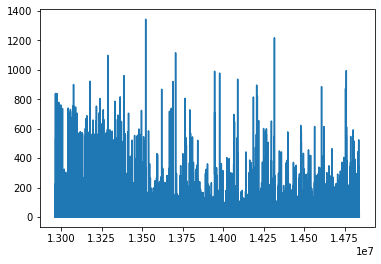

In [147]:
fig,ax = plt.subplots()
count_plot = pd.DataFrame(agg_binance_price_df)
count_plot.columns = ['tx_count']
ax.plot(count_plot.index, count_plot['tx_count'])

In [18]:
agg_binance_price_df = binance_price_df[['price', 'blockNum']]
agg_binance_price_df = agg_binance_price_df.set_index('blockNum')
agg_binance_price_df = agg_binance_price_df.groupby('blockNum').parallel_apply(np.mean)
agg_binance_price_df.to_csv("./data/price/binance_price.csv")

with open("./data/price/binance_price.pickle", "wb") as output_file:
    pickle.dump(agg_binance_price_df, output_file)
    
agg_binance_price_df

,price
blockNum,
12961718,2724.698571
12961719,2726.792308
12961720,2727.670000
12961721,2727.933333
12961722,2724.130000
...,...
14839994,2006.795000
14839995,2006.770000
14839996,2006.925000


# MakerDAO Median

In [21]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/maker_dao_eth_usd_median_{blockFrom}_{blockTo}.csv', index_col=False)
    cut_gap = int(len(df['Data'].iloc[0])/2)
    cut_start = 0
    for i, new_col in enumerate("price age".split(" ")):
        cut_end = cut_start + cut_gap
        df[new_col] = df['Data'].apply(lambda x: x[cut_start:cut_end])
        cut_start = cut_end
    del df['Data']
    df.sort_values(['blockNum', 'index'])
    blockFrom = blockTo
    df_list.append(df)

raw_maker_dao_median_df = pd.concat(df_list)
raw_maker_dao_median_df.tail()

,topic0,blockNum,index,price,age
98,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14916115,305,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
99,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917011,513,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
100,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917814,365,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
101,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917868,186,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...
102,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14918202,334,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...


In [22]:
def reformat_log_maker_dao_median(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'price age'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    return data
maker_dao_median_df = reformat_log_maker_dao_median(raw_maker_dao_median_df)
maker_dao_median_df.price = maker_dao_median_df.price * 10e-19
maker_dao_median_df.tail()

,topic0,blockNum,index,price,age
98,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14916115,305,1848.43,1654535902
99,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917011,513,1859.980054,1654549008
100,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917814,365,1811.0,1654561569
101,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14917868,186,1773.205,1654562456
102,0xb78ebc573f1f889ca9e1e0fb62c843c836f3d3a2e1f4...,14918202,334,1734.51,1654567020


In [32]:
maker_dao_median_price_df = maker_dao_median_df[['blockNum', 'price']].groupby("blockNum").parallel_apply(np.mean)[['price']]
coin_name = 'eth'
with open(f"./data/price/maker_dao_median_{coin_name}.pickle", "wb") as output_file:
    pickle.dump(maker_dao_median_price_df, output_file)
maker_dao_median_price_df

,price
blockNum,
12466894,2684.520000
12467027,2628.760000
12467111,2570.070000
12467235,2508.550000
12467307,2566.590000
...,...
14916115,1848.430000
14917011,1859.980054
14917814,1811.000000


# MakerDAO OSM

In [24]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/maker_dao_eth_usd_osm_{blockFrom}_{blockTo}.csv', index_col=False)
    cut_gap = int(len(df['Data'].iloc[0])/1)
    cut_start = 0
    for i, new_col in enumerate("price".split(" ")):
        cut_end = cut_start + cut_gap
        df[new_col] = df['Data'].apply(lambda x: x[cut_start:cut_end])
        cut_start = cut_end
    del df['Data']
    df.sort_values(['blockNum', 'index'])
    blockFrom = blockTo
    df_list.append(df)

raw_maker_dao_osm_df = pd.concat(df_list)
raw_maker_dao_osm_df.tail()

,topic0,blockNum,index,price
311,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14917960,88,0000000000000000000000000000000000000000000000...
312,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918226,373,0000000000000000000000000000000000000000000000...
313,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918481,180,0000000000000000000000000000000000000000000000...
314,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918738,32,0000000000000000000000000000000000000000000000...
315,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918979,120,0000000000000000000000000000000000000000000000...


In [25]:
def reformat_log_maker_dao_median(raw_data):
    data = copy.deepcopy(raw_data)
    for col_name in 'price'.split(' '):
        data[col_name] = raw_data[col_name].map(hex2int)
    return data
maker_dao_osm_df = reformat_log_maker_dao_median(raw_maker_dao_osm_df)
maker_dao_osm_df.price = maker_dao_osm_df.price * 10e-19
maker_dao_osm_df.tail()

,topic0,blockNum,index,price
311,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14917960,88,1859.980054
312,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918226,373,1773.205
313,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918481,180,1734.51
314,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918738,32,1734.51
315,0x296ba4ca62c6c21c95e828080cb8aec7481b71390585...,14918979,120,1734.51


In [33]:
maker_dao_osm_price_df = maker_dao_osm_df[['blockNum', 'price']].groupby("blockNum").parallel_apply(np.mean)[['price']]
coin_name = 'eth'
with open(f"./data/price/maker_dao_osm_{coin_name}.pickle", "wb") as output_file:
    pickle.dump(maker_dao_osm_price_df, output_file)
maker_dao_osm_price_df

,price
blockNum,
12466860,2628.869154
12467136,2628.869154
12467369,2570.070000
12467658,2566.590000
12467932,2692.410000
...,...
14917960,1859.980054
14918226,1773.205000
14918481,1734.510000


# Merge

In [3]:
with open(r"./data/price/uniswap_v2_eth_usdc.pickle", "rb") as output_file:
    uniswap_v2_price_df_usdc = pickle.load(output_file)
    uniswap_v2_price_df_usdc.columns = ['uniswap_v2_usdc_eth']

with open(r"./data/price/uniswap_v2_eth_usdt.pickle", "rb") as output_file:
    uniswap_v2_price_df_usdt = pickle.load(output_file)
    uniswap_v2_price_df_usdt.columns = ['uniswap_v2_usdt_eth']

with open(r"./data/price/chainlink_eth_usd.pickle", "rb") as output_file:
    chainlink_df_price = pickle.load(output_file)
    chainlink_df_price = chainlink_df_price[['current']]
    chainlink_df_price.columns = ['chainlink_usd_eth']

for coin_name in ['usdt', 'usdc']:
    for fee_pct in ['005', '03']:
        with open(f"./data/price/uniswap_v3_eth_{coin_name}_{fee_pct}.pickle", "rb") as output_file:
            exec(f"uniswap_v3_price_df_{coin_name}_{fee_pct} = pickle.load(output_file)")
            exec(f"uniswap_v3_price_df_{coin_name}_{fee_pct}.columns = ['uniswap_v3_{coin_name}_eth_{fee_pct}']")

with open("./data/price/binance_price.pickle", "rb") as output_file:
    agg_binance_price_df = pickle.load(output_file)
    agg_binance_price_df.columns = ['binance_usdc_eth']

with open(f"./data/price/maker_dao_median_eth.pickle", "rb") as output_file:
    maker_dao_median_price_df = pickle.load(output_file)
    maker_dao_median_price_df.columns = ['maker_dao_median_usd_eth']

with open(f"./data/price/maker_dao_osm_eth.pickle", "rb") as output_file:
    maker_dao_osm_price_df = pickle.load(output_file)
    maker_dao_osm_price_df.columns = ['maker_dao_osm_usd_eth']

In [4]:
price_df = pd.merge(chainlink_df_price,uniswap_v2_price_df_usdc,on='blockNum',how='outer')
price_df = pd.merge(price_df,uniswap_v2_price_df_usdt,on='blockNum',how='outer')
price_df = pd.merge(price_df,agg_binance_price_df,on='blockNum',how='outer')
price_df = pd.merge(price_df,maker_dao_median_price_df,on='blockNum',how='outer')
price_df = pd.merge(price_df,maker_dao_osm_price_df,on='blockNum',how='outer')

for coin_name in ['usdt', 'usdc']:
    for fee_pct in ['005', '03']:
        exec(f"price_df = pd.merge(price_df,uniswap_v3_price_df_{coin_name}_{fee_pct},on='blockNum',how='outer')")

fullBlockNum = pd.DataFrame(range(price_df.index[0], price_df.index[-1]), columns=['blockNum'])
price_df = pd.merge(price_df.reset_index(),fullBlockNum,on='blockNum',how='outer').set_index('blockNum').sort_index()

In [5]:
price_df = price_df.fillna(method="ffill")

london_update = 12980001
end_block = 14840000
price_df = price_df[price_df.index >= london_update]
price_df = price_df[price_df.index <= end_block]

In [6]:
price_df.tail(50)

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,maker_dao_median_usd_eth,maker_dao_osm_usd_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03
blockNum,,,,,,,,,,
14839951,1974.592132,2007.490968,2008.284413,2003.595000,2010.5,2010.5,2003.707876,2003.707876,2001.708839,2006.494489
14839952,1974.592132,2007.350237,2008.284413,2003.880769,2010.5,2010.5,2003.707876,2003.707876,2001.708839,2006.494489
14839953,1974.592132,2007.350237,2008.284413,2003.876667,2010.5,2010.5,2003.707876,2003.707876,2001.905826,2006.494489
14839954,1974.592132,2007.473819,2008.284413,2003.627778,2010.5,2010.5,2003.707876,2003.707876,2001.905826,2006.494489
14839955,1974.592132,2007.473819,2008.284413,2003.820000,2010.5,2010.5,2003.707876,2003.707876,2001.905826,2006.494489
14839956,1974.592132,2007.473819,2008.250671,2003.820000,2010.5,2010.5,2003.707876,2003.707876,2001.908335,2006.494489
14839957,1974.592132,2007.473819,2008.250671,2003.820000,2010.5,2010.5,2003.707876,2003.707876,2001.909684,2006.494489
14839958,1974.592132,2007.544240,2008.250671,2003.820000,2010.5,2010.5,2003.707876,2003.707876,2001.909684,2006.494489
14839959,1974.592132,2007.544240,2008.257752,2003.030000,2010.5,2010.5,2004.047266,2004.047266,2001.972074,2006.494489


In [23]:
price_df.to_csv("data/price/aggregated_price.csv")

In [24]:
price_df

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,maker_dao_median_usd_eth,maker_dao_osm_usd_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03
blockNum,,,,,,,,,,
12980001,3065.955606,3073.245245,3069.380681,3083.313889,3043.0,3043.0,3074.431238,3074.431238,3076.686515,3072.052103
12980002,3065.955606,3073.286147,3069.623338,3086.408235,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980003,3065.955606,3073.286147,3069.623338,3081.612000,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980004,3065.955606,3073.286147,3069.623338,3077.450000,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980005,3065.955606,3073.198156,3069.657611,3080.896667,3043.0,3043.0,3075.931207,3075.931207,3080.394993,3074.242536
...,...,...,...,...,...,...,...,...,...,...
14839996,1974.592132,2007.439830,2007.920146,2006.925000,2010.5,2010.5,2006.862073,2006.862073,2003.697706,2006.494489
14839997,1974.592132,2007.439830,2007.920146,2006.950000,2010.5,2010.5,2006.862073,2006.862073,2003.702396,2006.494489
14839998,1974.592132,2007.453919,2007.920146,2006.950000,2010.5,2010.5,2006.862073,2006.862073,2003.702396,2006.494489


# Plot Graph

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
price_df = pd.read_csv("data/price/aggregated_price.csv", index_col='blockNum')

In [2]:
price_df

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,maker_dao_median_usd_eth,maker_dao_osm_usd_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03
blockNum,,,,,,,,,,
12980001,3065.955606,3073.245245,3069.380681,3083.313889,3043.0,3043.0,3074.431238,3074.431238,3076.686515,3072.052103
12980002,3065.955606,3073.286147,3069.623338,3086.408235,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980003,3065.955606,3073.286147,3069.623338,3081.612000,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980004,3065.955606,3073.286147,3069.623338,3077.450000,3043.0,3043.0,3075.931207,3075.931207,3076.686515,3074.242536
12980005,3065.955606,3073.198156,3069.657611,3080.896667,3043.0,3043.0,3075.931207,3075.931207,3080.394993,3074.242536
...,...,...,...,...,...,...,...,...,...,...
14839996,1974.592132,2007.439830,2007.920146,2006.925000,2010.5,2010.5,2006.862073,2006.862073,2003.697706,2006.494489
14839997,1974.592132,2007.439830,2007.920146,2006.950000,2010.5,2010.5,2006.862073,2006.862073,2003.702396,2006.494489
14839998,1974.592132,2007.453919,2007.920146,2006.950000,2010.5,2010.5,2006.862073,2006.862073,2003.702396,2006.494489


In [5]:
13980001+150

13980151

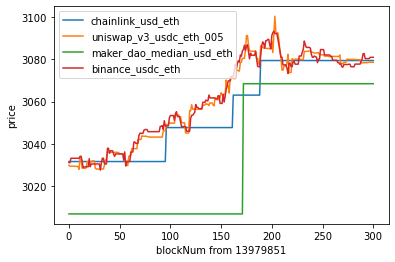

In [11]:
def plot_df(price_df, index_from=0, index_to=-1, plot_full=False, 
            plot_col_str='chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth',
            save=False):
    if not plot_full:
        price_df = price_df.loc[index_from:index_to, :]
    fig,ax = plt.subplots()
    # for name in price_df.columns:
    for name in plot_col_str.split(' '):
        ax.plot(range(len(price_df.index)), price_df[name],label=name)
    ax.set_xlabel(f"blockNum from {index_from}")
    ax.set_ylabel("price")
    ax.legend(loc='best')

    return fig

ax = plot_df(price_df, 13979851, 13980151, plot_col_str=plot_col_str)


In [19]:
ax.savefig("rawPrice.pdf", bbox_inches='tight')

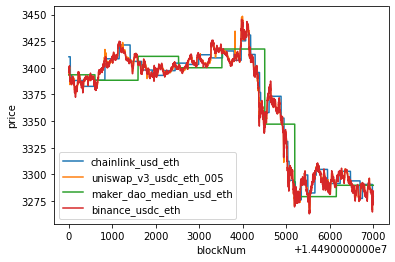

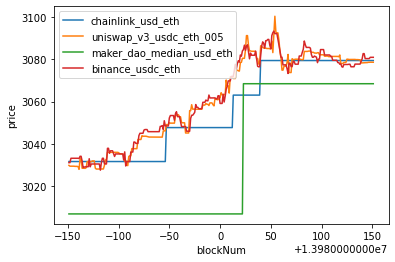

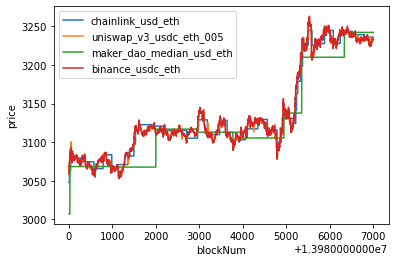

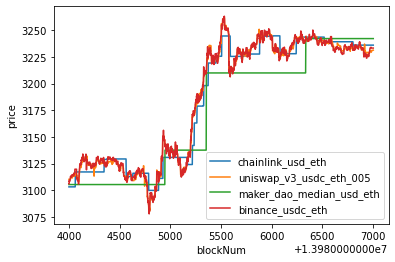

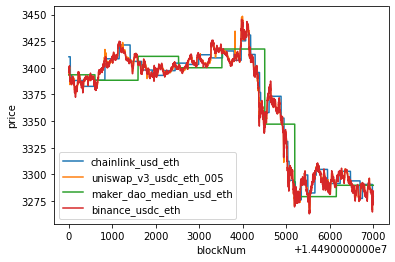

In [3]:
def plot_df(price_df, index_from=0, index_to=-1, plot_full=False, 
            plot_col_str='chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth',
            save=False):
    if not plot_full:
        price_df = price_df.loc[index_from:index_to, :]
    fig,ax = plt.subplots()
    # for name in price_df.columns:
    for name in plot_col_str.split(' '):
        ax.plot(price_df.index, price_df[name],label=name)
    ax.set_xlabel("blockNum")
    ax.set_ylabel("price")
    ax.legend(loc='best')
    return fig

# plot_df(price_df, 12980001, 12980001+2000)
plot_col_str='chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth binance_usdc_eth'
plot_df(price_df, 13980001-150, 13980001+150, plot_col_str=plot_col_str)
plot_df(price_df, 13980001, 13980001+7000, plot_col_str=plot_col_str)
plot_df(price_df, 13980001+4000, 13980001+7000, plot_col_str=plot_col_str)

plot_df(price_df, 13980001+510000, 13980001+517000, plot_col_str=plot_col_str)

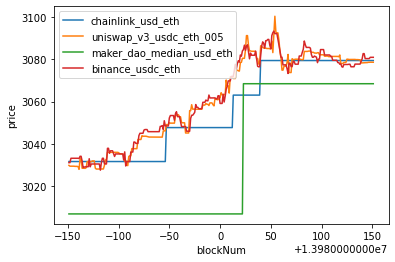

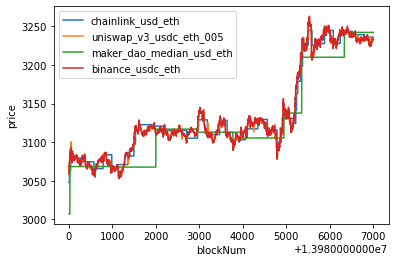

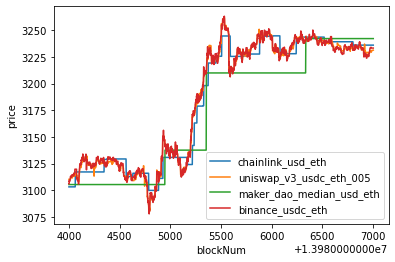

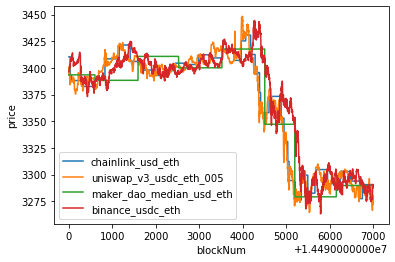

In [9]:
def plot_df(price_df, index_from=0, index_to=-1, plot_full=False, 
            plot_col_str='chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth'):
    if not plot_full:
        price_df = price_df.loc[index_from:index_to, :]
    fig,ax = plt.subplots()
    # for name in price_df.columns:
    for name in plot_col_str.split(' '):
        ax.plot(price_df.index, price_df[name],label=name)
    ax.set_xlabel("blockNum")
    ax.set_ylabel("price")
    ax.legend(loc='best')

# plot_df(price_df, 12980001, 12980001+2000)
plot_col_str='chainlink_usd_eth uniswap_v3_usdc_eth_005 maker_dao_median_usd_eth binance_usdc_eth'
plot_df(price_df, 13980001-150, 13980001+150, plot_col_str=plot_col_str)
plot_df(price_df, 13980001, 13980001+7000, plot_col_str=plot_col_str)
plot_df(price_df, 13980001+4000, 13980001+7000, plot_col_str=plot_col_str)

plot_df(price_df, 13980001+510000, 13980001+517000, plot_col_str=plot_col_str)
# plot_df(price_df, 12980001, 13180001)

# # plot_df(price_df, plot_full=True)
# 13980001+2000

# for i in range(1860041//10000):
#     plot_df(price_df, 12980001+5000*i, 12980001+5000*(i+1))


In [38]:
13000001 - 12980001

20000

In [61]:
price_df.loc[13521001:13523001, :]

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03
blockNum,,,,,,,,
13521001,4301.880000,4289.210551,4300.464128,4312.240000,4291.722024,4291.722024,4290.711694,4295.566740
13521002,4301.880000,4289.210551,4300.464128,4312.240000,4291.722024,4291.722024,4290.711694,4295.566740
13521003,4301.880000,4288.873324,4303.143614,4313.026667,4291.722024,4291.722024,4290.711694,4295.566740
13521004,4301.880000,4288.873324,4303.143614,4313.303333,4291.722024,4291.722024,4290.711694,4295.566740
13521005,4301.880000,4288.873324,4307.427705,4313.806667,4291.722024,4291.722024,4290.705735,4295.566740
...,...,...,...,...,...,...,...,...
13522997,4329.264357,4321.844516,4337.999123,4330.803333,4332.401895,4332.401895,4329.848358,4333.847803
13522998,4329.264357,4321.844516,4337.999123,4330.180000,4332.401895,4332.401895,4329.848358,4333.847803
13522999,4329.264357,4321.844516,4337.999123,4330.270000,4332.401895,4332.401895,4329.848358,4333.847803


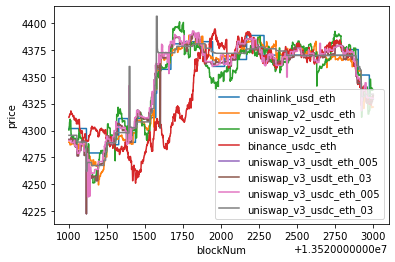

In [63]:
plot_df(price_df, 13521001, 13523001)

In [64]:
time_data_list = [] 
for i in range(0,7):
    tmp_df = pd.read_csv(f'data/crawled/blockTime_data_{i}.csv', index_col='blockNum')
    time_data_list.append(tmp_df)
# time_data_list.append(pd.read_csv(f'data/crawled/blockTime.csv', index_col='blockNum'))
time_data = pd.concat(time_data_list)
time_data = time_data.sort_index().drop_duplicates()
time_data['blockTime'] = pd.to_datetime(time_data['blockTime'],unit='s')
time_data

,blockTime
blockNum,
12466827,2021-05-19 19:56:12
12466828,2021-05-19 19:56:23
12466829,2021-05-19 19:56:28
12466830,2021-05-19 19:56:43
12466831,2021-05-19 19:56:46
...,...
14839997,2022-05-25 05:16:06
14839998,2022-05-25 05:16:22
14839999,2022-05-25 05:16:25


In [111]:
test_2_df = pd.read_csv('data/crawled/binance/unzip/ETHUSDC-trades-2021-10-30.csv', header=None)
test_2_df = test_2_df[[1,4]]
test_2_df.columns = ['price', 'time']
test_2_df['time'] = test_2_df['time'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1000))
test_2_df

,price,time
0,4420.40,2021-10-30 01:00:00.433
1,4418.93,2021-10-30 01:00:02.381
2,4419.10,2021-10-30 01:00:08.581
3,4419.10,2021-10-30 01:00:08.588
4,4419.10,2021-10-30 01:00:08.639
...,...,...
32811,4320.74,2021-10-31 00:59:52.660
32812,4320.80,2021-10-31 00:59:52.713
32813,4323.05,2021-10-31 00:59:55.719
32814,4323.09,2021-10-31 00:59:55.719


In [92]:
test_df = price_df.loc[13520991:13523001, :]
test_df = test_df.merge(time_data, how='left', on='blockNum')
test_df['blockTime chainlink_usd_eth uniswap_v3_usdc_eth_005 binance_usdc_eth'.split(' ')].head(20)

,blockTime,chainlink_usd_eth,uniswap_v3_usdc_eth_005,binance_usdc_eth
blockNum,,,,
13520991,2021-10-30 21:59:14,4301.88,4297.196112,4309.683333
13520992,2021-10-30 21:59:25,4301.88,4293.781565,4310.210000
13520993,2021-10-30 21:59:33,4301.88,4293.781565,4311.190000
13520994,2021-10-30 21:59:36,4301.88,4293.781565,4311.502500
13520995,2021-10-30 21:59:53,4301.88,4290.711694,4312.124000
13520996,2021-10-30 22:00:03,4301.88,4290.711694,4311.081000
13520997,2021-10-30 22:00:43,4301.88,4290.711694,4311.683000
13520998,2021-10-30 22:01:52,4301.88,4290.711694,4311.938750
13520999,2021-10-30 22:01:53,4301.88,4290.711694,4311.200000


In [161]:
test_df = price_df
test_df = test_df.merge(time_data, how='left', on='blockNum')

test_df[test_df.index == 13520900]
test_df[test_df.index == 13000900]
test_df[test_df.index == 13900900]

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03,blockTime
blockNum,,,,,,,,,
13900900,3786.297158,3775.258231,3778.733997,3780.325556,3786.141604,3786.141604,3784.325955,3777.853804,2021-12-29 14:57:59


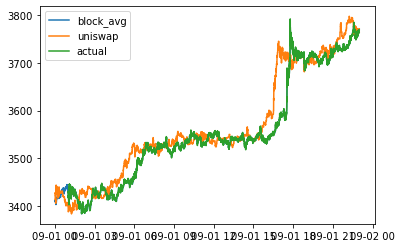

In [158]:
test_2_df = pd.read_csv('data/crawled/binance/unzip/ETHUSDC-trades-2021-09-01.csv', header=None)
test_2_df = test_2_df[[1,4]]
test_2_df.columns = ['price', 'time']
test_2_df['time'] = test_2_df['time'].apply(lambda x: datetime.datetime.fromtimestamp(float(x) / 1000))

test_df = price_df
test_df = test_df.merge(time_data, how='left', on='blockNum')

time_from =  pd.Timestamp(year=2021, month=9, day=1, hour=0)
time_to = pd.Timestamp(year=2021, month=9, day=1, hour=23)

test_df = test_df[test_df['blockTime'] >=  time_from]
test_df = test_df[test_df['blockTime'] <=  time_to]
test_2_df = test_2_df[test_2_df['time'] >=  time_from]
test_2_df = test_2_df[test_2_df['time'] <=  time_to]

fig,ax = plt.subplots()
ax.plot(test_df.blockTime, test_df['binance_usdc_eth'],label='block_avg')
ax.plot(test_df.blockTime, test_df['uniswap_v3_usdc_eth_005'],label='uniswap')
ax.plot(test_2_df.time, test_2_df['price'],label='actual')
ax.legend(loc='best')

In [185]:
test_df[test_df.index == 13522976]

,chainlink_usd_eth,uniswap_v2_usdc_eth,uniswap_v2_usdt_eth,binance_usdc_eth,uniswap_v3_usdt_eth_005,uniswap_v3_usdt_eth_03,uniswap_v3_usdc_eth_005,uniswap_v3_usdc_eth_03,blockTime
blockNum,,,,,,,,,
13522976,4329.264357,4326.78972,4318.530466,4325.58,4327.307784,4327.307784,4330.689882,4333.631965,2021-10-31 05:30:21


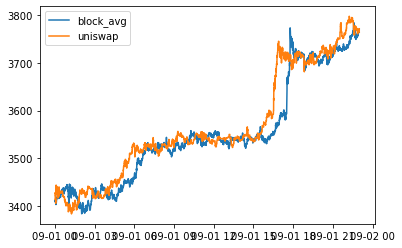

In [137]:
fig,ax = plt.subplots()
ax.plot(test_df.blockTime, test_df['binance_usdc_eth'],label='block_avg')
ax.plot(test_df.blockTime, test_df['uniswap_v3_usdc_eth_005'],label='uniswap')
# ax.plot(test_2_df.time, test_2_df['price'],label='actual')
ax.legend(loc='best')

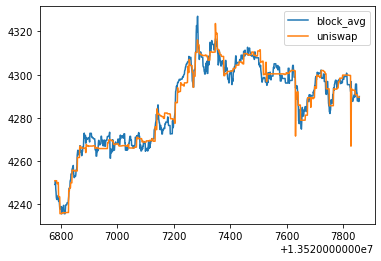

In [125]:
fig,ax = plt.subplots()
ax.plot(test_df.index, test_df['binance_usdc_eth'],label='block_avg')
ax.plot(test_df.index, test_df['uniswap_v3_usdc_eth_005'],label='uniswap')
ax.legend(loc='best')

In [126]:
test_df.index

Int64Index([13526779, 13526780, 13526781, 13526782, 13526783, 13526784,
            13526785, 13526786, 13526787, 13526788,
            ...
            13527849, 13527850, 13527851, 13527852, 13527853, 13527854,
            13527855, 13527856, 13527857, 13527858],
           dtype='int64', name='blockNum', length=1080)

In [10]:
(13522991 + 13520718)/2

13521855

13521854.5

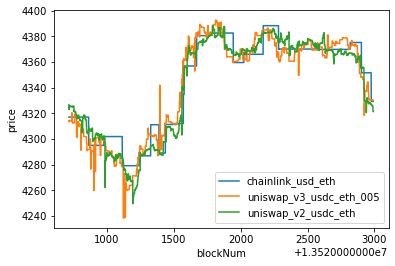

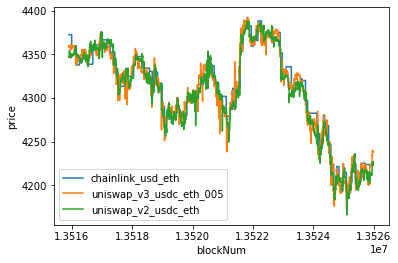

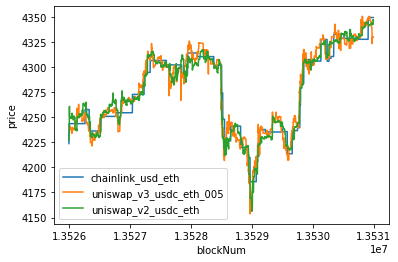

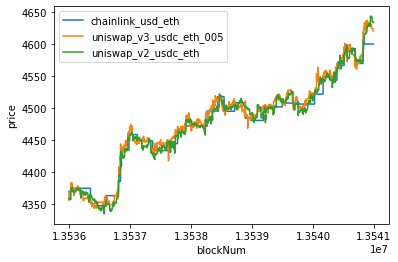

In [11]:
plot_df(price_df, 13520718, 13522991)
plot_df(price_df, 13520900-5000, 13520991+5000)
plot_df(price_df, 13520991+5000, 13520991+10000)
plot_df(price_df, 13520991+15000, 13520991+20000)

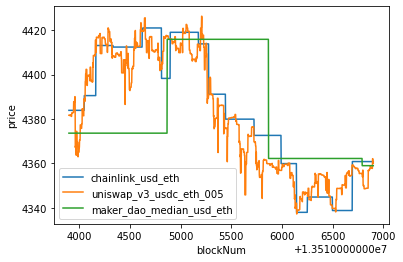

In [29]:
plot_df(price_df, 13520900-7000, 13520900-4000)

# Block Base Fee

In [104]:
df_list = []


for file_i in "0 1_1 2 3 4 5 6".split(' '):
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/blockBaseFee_data_{file_i}.csv', index_col=False)
    df.sort_values(['blockNum'])
    df_list.append(df)

blockBaseFee_df = pd.concat(df_list)
blockBaseFee_df = blockBaseFee_df.drop_duplicates()
blockBaseFee_df = blockBaseFee_df.dropna()
blockBaseFee_df = blockBaseFee_df.set_index('blockNum')
blockBaseFee_df = blockBaseFee_df[blockBaseFee_df['baseFee'] != '<nil>']
blockBaseFee_df['baseFee'] = blockBaseFee_df['baseFee'].apply(lambda x:int(x)/10**9)
blockBaseFee_df.tail()

,baseFee
blockNum,
14829996,51.038409
14829997,57.410739
14829998,56.942602
14829999,54.247902
14830000,57.259955


In [106]:
blockBaseFee_df.to_csv("data/price/blockBaseFee.csv")

# Chainlink Gas info

In [169]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/chainlink_eth_usd_gas_info_{blockFrom}_{blockTo}.csv', index_col=False)
    blockFrom = blockTo
    df_list.append(df)


chainlink_eth_usd_gas_info_df = pd.concat(df_list).sort_values(['blockNum', 'index'])
chainlink_eth_usd_gas_info_df

,blockNum,index,txHash,gas,gasPrice,gasTipCap,gasFeeCap
0,12466826,169,0xfa10370d60c86502d8e2da878a75cf0a754926887a7d...,500000,202000000000,202000000000,202000000000
1,12466847,255,0x310fd97b6328ded404e8591c2162a0d9ff4931802d83...,500000,182000000000,182000000000,182000000000
2,12466859,185,0x4ef4b76b41638656a9151a445dff660ded713f99fefc...,500000,188093018519,188093018519,188093018519
3,12466872,311,0x3fe513d83cfd761c01bcf3f08a8ec12cbaa31d109e42...,400000,178710000000,178710000000,178710000000
4,12466878,210,0x44ff92880f06bd3d3b141db65365adefd3496082da77...,500000,178000000000,178000000000,178000000000
...,...,...,...,...,...,...,...
263,14862210,45,0xd38d438c354b2c4029f781e90b425756513dea9f52e4...,500000,61620374252,2000000000,61620374252
264,14862344,112,0xee484566c886e794828f3656be82e6f8737ee7a83c58...,500000,17306184548,17306184548,17306184548
265,14862466,41,0x94003e1cd5ad9a14ca8a77b598eb4482d7a3c6e1dac6...,500000,63240007272,2000000000,63240007272
266,14862733,3,0x3a2afd0478d802974cd49bb1de0f48e301c1c550836b...,500000,20907108982,1510000000,20907108982


In [181]:
13522991
chainlink_eth_usd_gas_info_df[chainlink_eth_usd_gas_info_df['blockNum'] <= 13522991]

,blockNum,index,txHash,gas,gasPrice,gasTipCap,gasFeeCap
0,12466826,169,0xfa10370d60c86502d8e2da878a75cf0a754926887a7d...,500000,202000000000,202000000000,202000000000
1,12466847,255,0x310fd97b6328ded404e8591c2162a0d9ff4931802d83...,500000,182000000000,182000000000,182000000000
2,12466859,185,0x4ef4b76b41638656a9151a445dff660ded713f99fefc...,500000,188093018519,188093018519,188093018519
3,12466872,311,0x3fe513d83cfd761c01bcf3f08a8ec12cbaa31d109e42...,400000,178710000000,178710000000,178710000000
4,12466878,210,0x44ff92880f06bd3d3b141db65365adefd3496082da77...,500000,178000000000,178000000000,178000000000
...,...,...,...,...,...,...,...
919,13522561,158,0x5bbbb0e893fd97bed006735611fcce305a7cb83e7fe0...,500000,150700000000,150700000000,150700000000
920,13522819,376,0x9ffcf133254885ff6696a0e7f73214cb5523697d1cd1...,500000,121724624418,121724624418,121724624418
921,13522829,56,0xbf7aab92d00c814fc40d75c74e70041cece2ee577bd8...,500000,128700000000,128700000000,128700000000
922,13522903,47,0xbbc990347cf83a4d64dfe7b30def7c4450a7f723f627...,500000,141000000000,141000000000,141000000000


In [184]:
print(chainlink_eth_usd_gas_info_df[chainlink_eth_usd_gas_info_df['blockNum'] == 13522976]['txHash'].iloc[0])

0xe525625a2a9afd18372d93c9cdfe565d6dcdc02867bb332c8873cff82bf9b2e5


In [150]:

chainlink_eth_usd_gas_info_df[chainlink_eth_usd_gas_info_df['txHash'] == '0x6196900d942944b63a305a704a3a32c7d0c0b2e9db03a9220bcc8fc2a3ba1ddc']

,blockNum,index,txHash,gas,gasPrice,gasTipCap,gasFeeCap
224,14857660,297,0x6196900d942944b63a305a704a3a32c7d0c0b2e9db03...,500000,58586170044,2000000000,58586170044


In [146]:
df_list = []
blockFrom = 12466826
blockGap = 118602
blockMax = 14838875

while blockFrom <= blockMax:
    blockTo = blockFrom + blockGap
    df = pd.read_csv(f'data/crawled/chainlink_eth_usd_gas_info_{blockFrom}_{blockTo}.csv', index_col=False)
    blockFrom = blockTo
    df_list.append(df)


chainlink_eth_usd_gas_info_df = pd.concat(df_list).sort_values(['blockNum', 'index'])
for col_name in ['gasPrice', 'gasTipCap', 'gasFeeCap']:
    chainlink_eth_usd_gas_info_df[col_name] = chainlink_eth_usd_gas_info_df[col_name].apply(lambda x:int(x)/10**9)
chainlink_eth_usd_gas_info_df = chainlink_eth_usd_gas_info_df.set_index('blockNum')
chainlink_eth_usd_gas_info_df = chainlink_eth_usd_gas_info_df[['index','gas', 'gasPrice', 'gasTipCap', 'gasFeeCap']]

chainlink_eth_usd_gas_info_df = price_df[['chainlink_usd_eth']].merge(chainlink_eth_usd_gas_info_df,on='blockNum',how='left')
del chainlink_eth_usd_gas_info_df['chainlink_usd_eth']
chainlink_eth_usd_gas_info_df = chainlink_eth_usd_gas_info_df.fillna(method="ffill")
chainlink_eth_usd_gas_info_df.tail()

,index,gas,gasPrice,gasTipCap,gasFeeCap
blockNum,,,,,
14857051,139.0,500000.0,94.730628,2.0,94.730628
14857053,139.0,500000.0,94.730628,2.0,94.730628
14857054,139.0,500000.0,94.730628,2.0,94.730628
14857058,139.0,500000.0,94.730628,2.0,94.730628
14857061,139.0,500000.0,94.730628,2.0,94.730628


In [148]:
chainlink_eth_usd_gas_info_df.to_csv("data/price/chainlink_eth_usd_gas_info.csv")

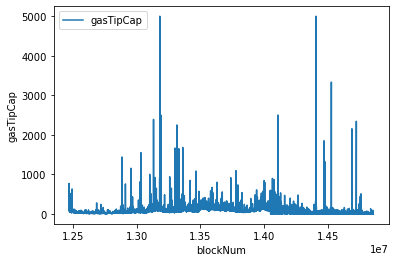

In [147]:
fig,ax = plt.subplots()

ax.plot(chainlink_eth_usd_gas_info_df.index, chainlink_eth_usd_gas_info_df['gasTipCap'],label='gasTipCap')
ax.set_xlabel("blockNum")
ax.set_ylabel("gasTipCap")
ax.legend(loc='best')

In [121]:
chainlink_eth_usd_gas_info_df['gasTipCap'].max()

5000.0

In [123]:
chainlink_eth_usd_gas_info_df[chainlink_eth_usd_gas_info_df['gasTipCap'] > 4000]

,index,txHash,gas,gasPrice,gasTipCap,gasFeeCap
blockNum,,,,,,
13180445,21,0x93d0d6aef739b20e4f24d8f82304168435bc5916f8db...,500000,5000.0,5000.0,5000.0
14407339,34,0x42fec9bbcd950c286994bb60ba974618a3eee5bec279...,500000,5000.0,5000.0,5000.0


Estimates a VAR by OLS per equation. The model is of the following form:

$$ \bold{y}_t = A_1 \bold{y}_{t-1} + \ldots + A_p \bold{y}_{t-p} + CD_t + \bold{u}_t $$

where \(\bold{y}_t\) is a \(K \times 1\) vector of endogenous variables and \(u_t\) assigns a spherical disturbance term of the same dimension. The coefficient matrices \(A_1, \ldots, A_p\) are of dimension \(K \times K\). In addition, either a constant and/or a trend can be included as deterministic regressors as well as centered seasonal dummy variables and/or exogenous variables (term \(CD_T\), by setting the type argument to the corresponding value and/or setting season to the desired frequency (integer) and/or providing a matrix object for exogen, respectively. The default for type is const and for season and exogen the default is set to NULL. Based on the same sample size the following information criteria and the final prediction error are computed: $$ AIC(n) = \ln \det(\tilde{\Sigma}_u(n)) + \frac{2}{T}n K^2 \quad, $$ $$ HQ(n) = \ln \det(\tilde{\Sigma}_u(n)) + \frac{2 \ln(\ln(T))}{T}n K^2 \quad, $$ $$ SC(n) = \ln \det(\tilde{\Sigma}_u(n)) + \frac{\ln(T)}{T}n K^2 \quad, $$



$$ FPE(n) = \left ( \frac{T + n^*}{T - n^*} \right )^K \det(\tilde{\Sigma}_u(n)) \quad $$

 ,  with $$\(\tilde{\Sigma}_u (n) = T^{-1} \sum_{t=1}^T \bold{\hat{u}}_t \bold{\hat{u}}_t'\)$$ and \(n^*\) is the total number of the parameters in each equation and \(n\) assigns the lag order.